In [1]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from collections import OrderedDict
from tqdm.notebook import trange

import matplotlib.pyplot as plt
import matplotlib as mpl

from function.utilities import get_subset

# param

In [11]:
#####CHANGE HERE#####
algorithm = "VLXT"
#####CHANGE HERE#####

In [12]:
aa_sort = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]

sample_nums_for_rbp = 1533
sample_nums_for_mrbp = 688
sample_times = 100

table_s2tos5_path = Path('./output/table_s2~s5')
table_s6_path = Path('./output/table_s6')

# load data

In [13]:
pondr_disorder_ident_path = Path("./output/pondr_disorder_ident")
od_human_df = pd.read_pickle(pondr_disorder_ident_path / "{}_od_human_df.pkl".format(algorithm))
od_rbp_df = get_subset(od_human_df, "rbp")
od_mrbp_df = get_subset(od_human_df, "mrbp")

# relative ratio stat

In [14]:
def aa_content(df):
    order_sequence_all = ""
    disorder_sequence_all = ""
    aa_sort_od = aa_sort + ["*"]

    for index, row in df.iterrows():
        uniprot_id = row["uniprot_id"]
        order_sequence = row["order_sequence"]
        disorder_sequence = row["disorder_sequence"]

        order_sequence_all = order_sequence_all + order_sequence
        disorder_sequence_all = disorder_sequence_all + disorder_sequence

    order_sequence_dict = OrderedDict({i: order_sequence_all.count(i) for i in aa_sort_od})
    order_sequence_dict["total"] = sum(order_sequence_dict.values())

    disorder_sequence_dict = OrderedDict({i: disorder_sequence_all.count(i) for i in aa_sort_od})
    disorder_sequence_dict["total"] = sum(disorder_sequence_dict.values())

    return {"order": order_sequence_dict, 
            "disorder": disorder_sequence_dict}

def subset_human_ratio(subset, human):

    subset_percent = [subset["disorder"][x] / (subset["order"][x] + subset["disorder"][x]) for x in aa_sort]
    human_percent = [human["disorder"][x] / (human["order"][x] + human["disorder"][x]) for x in aa_sort]

    ratio = [np.log(i / j) for i, j in zip(subset_percent, human_percent)]

    return {"aa_sort": aa_sort, 
            "ratio": ratio}


def population(od_subset_df, human_df):
    ratio_matrix = np.zeros((1, 20))
    human_content = aa_content(human_df)
    subset_content = aa_content(od_subset_df)

    subset_human_ratio_dict = subset_human_ratio(subset_content, human_content)
    ratio = subset_human_ratio_dict["ratio"]
    aa_sort = subset_human_ratio_dict["aa_sort"]

    ratio_matrix[0][:] = ratio

    return {"aa_sort": aa_sort, 
            "ratio_matrix": ratio_matrix}


def sample(od_human_df, sample_nums=1542, sample_times=50):

    ratio_matrix = np.zeros((sample_times, 20))
    human_content = aa_content(od_human_df)

    t = trange(sample_times, leave=True)
    for i in t:
        t.set_description("sampling {} human subset {} times".format(sample_nums, sample_times))
        t.refresh()

        sampled_df = od_human_df.sample(sample_nums)
        human_sampled_content = aa_content(sampled_df)

        subset_human_ratio_dict = subset_human_ratio(
            human_sampled_content, human_content
        )
        ratio = subset_human_ratio_dict["ratio"]
        aa_sort = subset_human_ratio_dict["aa_sort"]

        ratio_matrix[i][:] = ratio

    return {"aa_sort": aa_sort, 
            "ratio_matrix": ratio_matrix}

In [15]:
rbp_population_dict = population(od_rbp_df, od_human_df)
human_sample_for_rbp = sample(od_human_df, sample_nums=sample_nums_for_rbp, sample_times=sample_times)

mrbp_population_dict = population(od_mrbp_df, od_human_df)
human_sample_for_mrbp = sample(od_human_df, sample_nums=sample_nums_for_mrbp, sample_times=sample_times)

output = {
    "aa_sort": rbp_population_dict["aa_sort"],
    "rbp": {"population": rbp_population_dict["ratio_matrix"],
            "human_sample": human_sample_for_rbp["ratio_matrix"],
            },
    "mrbp": {"population": mrbp_population_dict["ratio_matrix"],
             "human_sample": human_sample_for_mrbp["ratio_matrix"],
            },
    }

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# plot

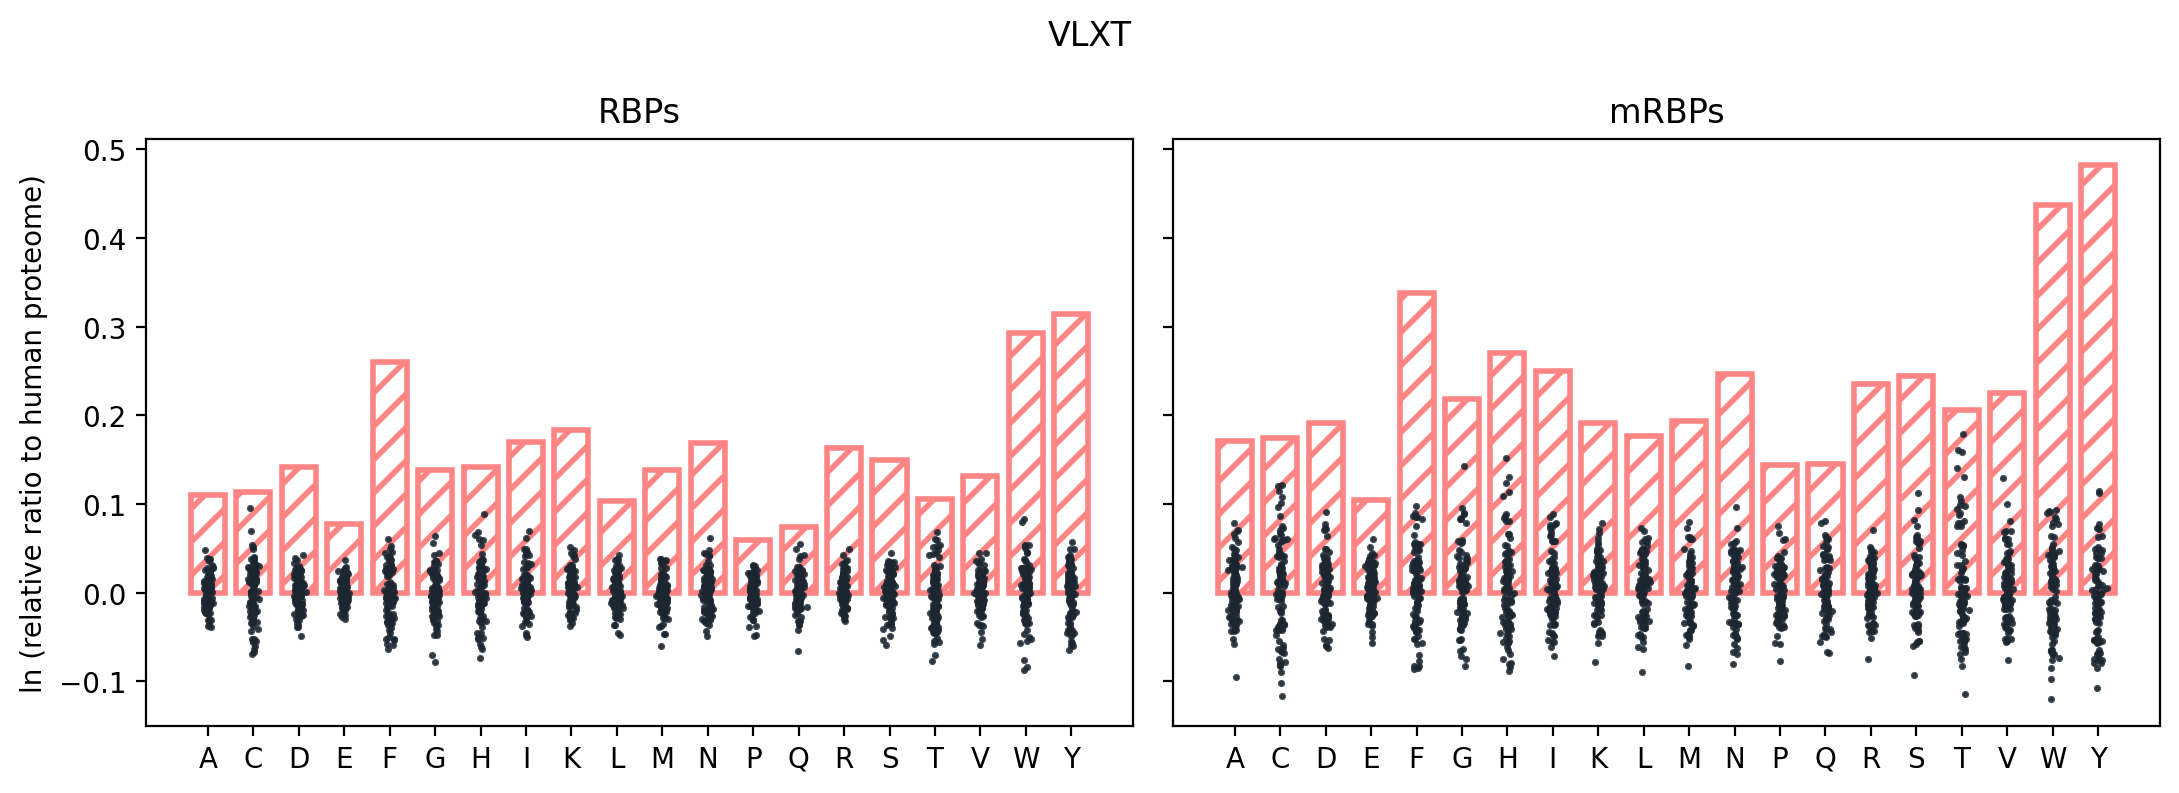

In [16]:
mpl.rcParams["hatch.linewidth"] = 2
f, (a0, a1) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11, 4), dpi=200)

X = np.arange(len(aa_sort))

noise = np.random.normal(0, 0.05, (output["rbp"]["human_sample"].shape))
for index, i in enumerate(output["rbp"]["human_sample"]):
    a0.scatter(X + noise[index], i, color=(0.105, 0.149, 0.192, 0.8), s=2.5, zorder=10)
a0.bar(X, output["rbp"]["population"][0], width=0.75, tick_label=aa_sort, zorder=0, color="white", hatch="//", linewidth=2, edgecolor="#ff8484",)
a0.set_title("RBPs")
a0.set_ylabel("ln (relative ratio to human proteome)")

noise = np.random.normal(0, 0.05, (output["mrbp"]["human_sample"].shape))
for index, i in enumerate(output["mrbp"]["human_sample"]):
    a1.scatter(X + noise[index], i, color=(0.105, 0.149, 0.192, 0.8), s=2.5, zorder=10)
a1.bar(X, output["mrbp"]["population"][0], width=0.75, tick_label=aa_sort, zorder=0, color="white", hatch="//", linewidth=2, edgecolor="#ff8484",)
a1.set_title("mRBPs")
# a1.set_ylim(-0.2, 0.6)

f.suptitle(algorithm)
f.tight_layout()

# table s2~s5 output

In [17]:
rbp = aa_content(od_rbp_df)
mrbp = aa_content(od_mrbp_df)
human = aa_content(od_human_df)

In [18]:
df = pd.DataFrame()

df["aa"] = rbp['order'].keys()

df["rbp_order"] = rbp['order'].values()
df["rbp_disorder"] = rbp['disorder'].values()

df["mrbp_order"] = mrbp['order'].values()
df["mrbp_disorder"] = mrbp['disorder'].values()

df["human_order"] = human['order'].values()
df["human_disorder"] = human['disorder'].values()

df.to_excel(table_s2tos5_path/"{}.xlsx".format(algorithm))
df

,aa,rbp_order,rbp_disorder,mrbp_order,mrbp_disorder,human_order,human_disorder
0,A,33756,27753,15937,14705,474415,321897
1,C,12347,2659,5352,1241,220009,41333
2,D,27212,18477,13251,9794,349268,188768
3,E,31845,36203,15337,18483,409580,396968
4,F,25329,4882,12213,2585,362796,51625
5,G,32054,26374,15769,15087,452912,293467
6,H,15428,6539,6987,3574,220858,76954
7,I,26300,11065,12346,5835,369522,123116
8,K,34785,26352,16120,12382,417435,233546
9,L,54416,25921,24425,12994,802230,329184


# table s6 output

In [19]:
df = pd.DataFrame()

df['random_1533_ave'] = np.mean(human_sample_for_rbp['ratio_matrix'],axis=0)
df['random_1533_std'] = np.std(human_sample_for_rbp['ratio_matrix'],axis=0)
df['random_1533_max'] = np.max(human_sample_for_rbp['ratio_matrix'],axis=0)
df['random_1533_min'] = np.min(human_sample_for_rbp['ratio_matrix'],axis=0)

df['random_688_ave'] = np.mean(human_sample_for_mrbp['ratio_matrix'],axis=0)
df['random_688_std'] = np.std(human_sample_for_mrbp['ratio_matrix'],axis=0)
df['random_688_max'] = np.max(human_sample_for_mrbp['ratio_matrix'],axis=0)
df['random_688_min'] = np.min(human_sample_for_mrbp['ratio_matrix'],axis=0)

df = round(df,2)

df.to_excel(table_s6_path/"{}.xlsx".format(algorithm))
df

,random_1533_ave,random_1533_std,random_1533_max,random_1533_min,random_688_ave,random_688_std,random_688_max,random_688_min
0,0.00,0.02,0.05,-0.04,0.00,0.03,0.08,-0.09
1,0.00,0.03,0.10,-0.07,0.01,0.05,0.12,-0.12
2,0.00,0.02,0.04,-0.05,0.01,0.03,0.09,-0.06
3,0.00,0.01,0.04,-0.03,0.00,0.02,0.06,-0.06
4,-0.00,0.03,0.06,-0.06,0.00,0.04,0.10,-0.09
5,-0.00,0.02,0.06,-0.08,0.00,0.04,0.14,-0.08
6,0.00,0.03,0.09,-0.07,0.00,0.05,0.15,-0.09
7,0.00,0.02,0.07,-0.05,0.01,0.04,0.09,-0.07
8,0.00,0.02,0.05,-0.04,0.01,0.03,0.08,-0.08
9,0.00,0.02,0.04,-0.05,0.00,0.03,0.07,-0.09
